# 05 — Model Optimization & Final Selection
## HumanForYou — Employee Attrition Prediction

---

### Objective

**Fine-tune the top models** from the benchmark to maximize predictive performance:
1. Hyperparameter tuning via GridSearchCV / RandomizedSearchCV
2. Threshold calibration to optimize the Precision-Recall trade-off
3. Feature importance analysis (SHAP for explainability)
4. Fairness evaluation on sensitive variables
5. Final model selection and business recommendations

> **Adapted from** the confidence calibration methodology used in a previous detection project — same threshold optimization logic applied to classification.

> This notebook expects preprocessed data from **03** and benchmark results from **04**!

## Section 1: Setup

In [16]:
# ==============================================================================
# IMPORTS
# ==============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
import joblib
from pathlib import Path

# Only suppress expected warnings, not real errors
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix,
    roc_curve, precision_recall_curve, make_scorer
)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

plt.rcParams.update({"figure.figsize": (12, 6), "figure.dpi": 100})
sns.set_theme(style="whitegrid")

# --- Path Configuration ---
_cwd = Path.cwd()
if (_cwd / "data" / "raw").exists():
    PROJECT_ROOT = _cwd
elif (_cwd.parent / "data" / "raw").exists():
    PROJECT_ROOT = _cwd.parent
else:
    raise FileNotFoundError(
        "Cannot find project root: 'data/raw/' not found in CWD or parent. "
        "Run this notebook from the project root or notebooks/ directory."
    )

OUTPUT_DIR = str(PROJECT_ROOT / "outputs")

# Load data — non-SMOTE for honest evaluation (consistent with NB04)
# class_weight='balanced' / scale_pos_weight handle imbalance natively.
X_train = pd.read_csv(f"{OUTPUT_DIR}/X_train.csv")
X_test  = pd.read_csv(f"{OUTPUT_DIR}/X_test.csv")
y_train = pd.read_csv(f"{OUTPUT_DIR}/y_train.csv").squeeze()
y_test  = pd.read_csv(f"{OUTPUT_DIR}/y_test.csv").squeeze()

# Feature count verification:
# Features selected by hybrid selection (NB03 whitelist)
# -> may be fewer after the correlation filter (|r| > 0.90) removes one feature
#   from a highly-correlated pair (e.g. Department_Sales <-> Department_R&D).
# Both 20-24 are valid depending on whether the correlation filter triggers.
n_features = X_train.shape[1]
assert 20 <= n_features <= 24, (
    f"Expected 20–24 features after selection + correlation filter, got {n_features}. "
    f"Check NB03 pipeline output."
)
print(f"Feature count: {n_features} (selected -> {n_features} after correlation filter)")

# Load benchmark results to pick top models
benchmark = pd.read_csv(f"{OUTPUT_DIR}/model_benchmark_results.csv")
print(f"Train: {X_train.shape} (non-SMOTE) | Test: {X_test.shape}")
print(f"\nTop 3 from benchmark:")
print(benchmark.head(3)[["Model", "F1-Score", "AUC-ROC"]].to_string(index=False))

Feature count: 22 (selected -> 22 after correlation filter)
Train: (3528, 22) (non-SMOTE) | Test: (882, 22)

Top 3 from benchmark:
        Model  F1-Score  AUC-ROC
      XGBoost  0.989324 0.998401
          MLP  0.989324 0.992263
Random Forest  0.985714 0.998330


## Section 2: Hyperparameter Tuning

Tune the top candidate models using GridSearchCV with stratified 5-fold cross-validation.

> **Note**: We tune on non-SMOTE data with `class_weight='balanced'` to let the model handle imbalance natively during CV.

In [17]:
# ==============================================================================
# HYPERPARAMETER GRIDS
# ==============================================================================

TUNING_CONFIGS = {
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42, n_jobs=-1, class_weight="balanced"),
        "params": {
            "n_estimators": [100, 200, 300],
            "max_depth": [10, 15, 20, None],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4],
        }
    },
    "XGBoost": {
        "model": XGBClassifier(random_state=42, eval_metric="logloss", verbosity=0),
        "params": {
            "n_estimators": [100, 200, 300],
            "max_depth": [3, 5, 7, 9],
            "learning_rate": [0.01, 0.05, 0.1, 0.2],
            "subsample": [0.7, 0.8, 1.0],
            "scale_pos_weight": [1, 3, 5],
        }
    },
    "Gradient Boosting": {
        "model": GradientBoostingClassifier(random_state=42),
        "params": {
            "n_estimators": [100, 200, 300],
            "max_depth": [3, 5, 7],
            "learning_rate": [0.01, 0.05, 0.1],
            "min_samples_split": [2, 5, 10],
            "subsample": [0.7, 0.8, 1.0],
        }
    },
}

print(f"Tuning {len(TUNING_CONFIGS)} models...")
for name, cfg in TUNING_CONFIGS.items():
    n_combos = np.prod([len(v) for v in cfg["params"].values()])
    print(f"  {name}: {n_combos} parameter combinations")

Tuning 3 models...
  Random Forest: 108 parameter combinations
  XGBoost: 432 parameter combinations
  Gradient Boosting: 243 parameter combinations


In [18]:
# ==============================================================================
# GRID SEARCH / RANDOMIZED SEARCH
# ==============================================================================

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
tuned_models = {}

for name, cfg in TUNING_CONFIGS.items():
    print(f"\n{'='*60}")
    print(f"Tuning: {name}")
    print(f"{'='*60}")
    
    n_combos = np.prod([len(v) for v in cfg["params"].values()])
    
    # Use RandomizedSearchCV if search space is large
    if n_combos > 200:
        search = RandomizedSearchCV(
            cfg["model"], cfg["params"], n_iter=50,
            scoring="f1", cv=cv, n_jobs=-1, random_state=42, verbose=0
        )
        search_type = "RandomizedSearchCV (50 iters)"
    else:
        search = GridSearchCV(
            cfg["model"], cfg["params"],
            scoring="f1", cv=cv, n_jobs=-1, verbose=0
        )
        search_type = "GridSearchCV"
    
    t0 = time.time()
    search.fit(X_train, y_train)
    elapsed = time.time() - t0
    
    tuned_models[name] = search.best_estimator_
    
    print(f"  Search: {search_type}")
    print(f"  Best F1 (CV): {search.best_score_:.4f}")
    print(f"  Best params:  {search.best_params_}")
    print(f"  Time: {elapsed:.1f}s")


Tuning: Random Forest
  Search: GridSearchCV
  Best F1 (CV): 0.9298
  Best params:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
  Time: 68.0s

Tuning: XGBoost
  Search: RandomizedSearchCV (50 iters)
  Best F1 (CV): 0.9265
  Best params:  {'subsample': 0.8, 'scale_pos_weight': 1, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2}
  Time: 11.5s

Tuning: Gradient Boosting
  Search: RandomizedSearchCV (50 iters)
  Best F1 (CV): 0.9284
  Best params:  {'subsample': 0.7, 'n_estimators': 300, 'min_samples_split': 2, 'max_depth': 5, 'learning_rate': 0.1}
  Time: 50.7s


## Section 3: Threshold Calibration

For each tuned model, sweep classification thresholds to find the **optimal operating point** that balances Precision and Recall for HumanForYou's business needs.

> In HR attrition, **Recall is slightly more valuable** than Precision — missing an at-risk employee is more costly than a false alert.

Random Forest — Optimal threshold: 0.57 (calibrated on CV)
  CV:   Prec=0.9940  Rec=0.8752  F1=0.9308
  Test: Prec=1.0000  Rec=0.9577  F1=0.9784
XGBoost — Optimal threshold: 0.69 (calibrated on CV)
  CV:   Prec=0.9824  Rec=0.8822  F1=0.9296
  Test: Prec=1.0000  Rec=0.9789  F1=0.9893
Gradient Boosting — Optimal threshold: 0.45 (calibrated on CV)
  CV:   Prec=0.9695  Rec=0.8928  F1=0.9296
  Test: Prec=1.0000  Rec=0.9718  F1=0.9857


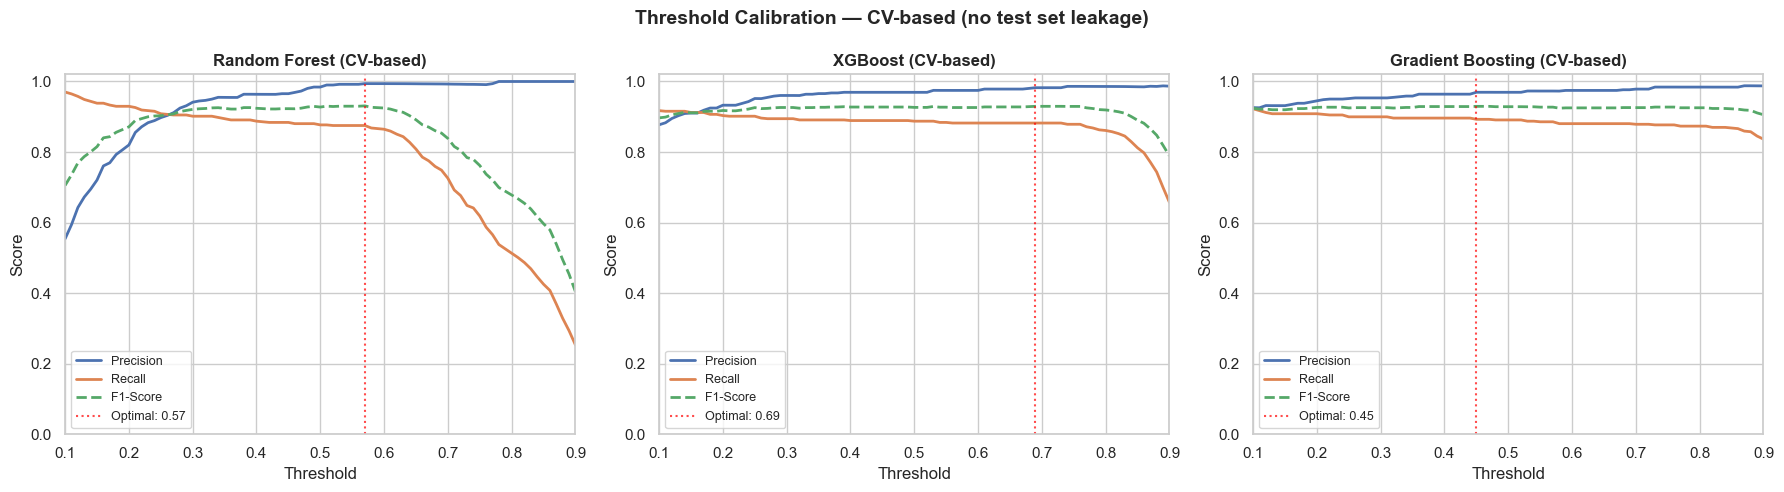

In [19]:
# ==============================================================================
# THRESHOLD CALIBRATION — CV-based (no test set leakage)
# ==============================================================================
# CORRECTED: Thresholds are now calibrated on out-of-fold CV predictions,
# NOT on the test set. This avoids optimistic bias from tuning on held-out data.
# The test set is used ONLY for final evaluation with the fixed threshold.

from sklearn.model_selection import cross_val_predict

def calibrate_threshold_cv(model, X_train, y_train, name, cv=5, target_recall=0.60):
    """
    Calibrate classification threshold using cross-validated predictions.
    
    1. Get out-of-fold probabilities via cross_val_predict
    2. Sweep thresholds on CV predictions to find optimal F1 (with recall floor)
    3. Return the threshold — to be applied unchanged to the test set
    """
    cv_strat = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    
    # Out-of-fold probabilities (each sample predicted by a model that never saw it)
    y_proba_cv = cross_val_predict(
        model.__class__(**model.get_params()), X_train, y_train,
        cv=cv_strat, method="predict_proba", n_jobs=-1
    )[:, 1]
    
    thresholds = np.arange(0.10, 0.91, 0.01)
    records = []
    
    for t in thresholds:
        y_pred = (y_proba_cv >= t).astype(int)
        prec = precision_score(y_train, y_pred, zero_division=0)
        rec  = recall_score(y_train, y_pred, zero_division=0)
        f1   = f1_score(y_train, y_pred, zero_division=0)
        records.append({"threshold": t, "precision": prec, "recall": rec, "f1": f1})
    
    df_cal = pd.DataFrame(records)
    
    # Best threshold: maximize F1 where recall >= target
    candidates = df_cal[df_cal["recall"] >= target_recall]
    if len(candidates) > 0:
        best_row = candidates.loc[candidates["f1"].idxmax()]
    else:
        best_row = df_cal.loc[df_cal["f1"].idxmax()]
    
    return df_cal, best_row, y_proba_cv

calibration_results = {}
fig, axes = plt.subplots(1, len(tuned_models), figsize=(6 * len(tuned_models), 5))
if len(tuned_models) == 1:
    axes = [axes]

for i, (name, model) in enumerate(tuned_models.items()):
    df_cal, best, y_proba_cv = calibrate_threshold_cv(model, X_train, y_train, name)
    
    # Evaluate on test set with fixed threshold (no re-tuning)
    model.fit(X_train, y_train)
    y_proba_test = model.predict_proba(X_test)[:, 1]
    y_pred_test = (y_proba_test >= best["threshold"]).astype(int)
    test_f1 = f1_score(y_test, y_pred_test)
    test_prec = precision_score(y_test, y_pred_test, zero_division=0)
    test_rec = recall_score(y_test, y_pred_test)
    
    calibration_results[name] = {
        "table": df_cal,
        "best": best,
        "test": {"precision": test_prec, "recall": test_rec, "f1": test_f1},
        "y_proba_cv": y_proba_cv,
    }

    axes[i].plot(df_cal["threshold"], df_cal["precision"], label="Precision", linewidth=2)
    axes[i].plot(df_cal["threshold"], df_cal["recall"], label="Recall", linewidth=2)
    axes[i].plot(df_cal["threshold"], df_cal["f1"], label="F1-Score", linewidth=2, linestyle="--")
    axes[i].axvline(best["threshold"], color="red", linestyle=":", alpha=0.7,
                    label=f"Optimal: {best['threshold']:.2f}")
    axes[i].set_xlabel("Threshold")
    axes[i].set_ylabel("Score")
    axes[i].set_title(f"{name} (CV-based)", fontweight="bold")
    axes[i].legend(fontsize=9)
    axes[i].set_xlim(0.1, 0.9)
    axes[i].set_ylim(0, 1.02)
    
    print(f"{name} — Optimal threshold: {best['threshold']:.2f} (calibrated on CV)")
    print(f"  CV:   Prec={best['precision']:.4f}  Rec={best['recall']:.4f}  F1={best['f1']:.4f}")
    print(f"  Test: Prec={test_prec:.4f}  Rec={test_rec:.4f}  F1={test_f1:.4f}")

plt.suptitle("Threshold Calibration — CV-based (no test set leakage)", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/threshold_calibration.png", bbox_inches="tight")
plt.show()

## Section 4: Feature Importance & Explainability

Use both built-in feature importances and SHAP values for interpretability.

> **ALTAI Requirement 4 (Transparency)**: The model must be explainable to HR stakeholders.

Detailed analysis on: Random Forest


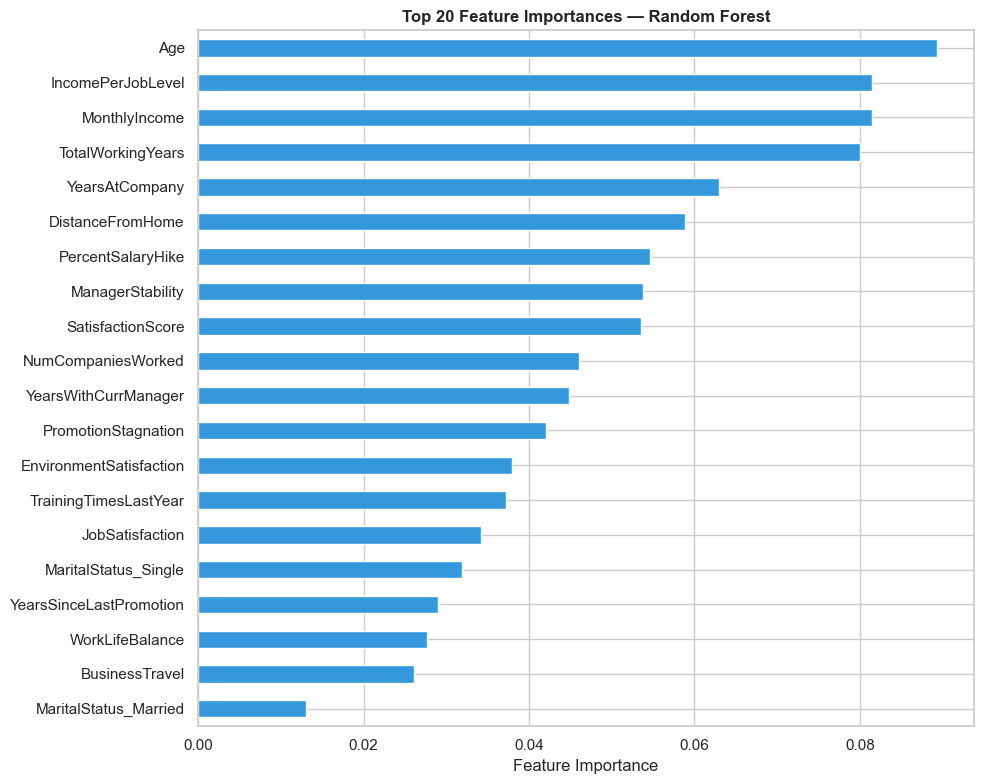

In [20]:
# ==============================================================================
# FEATURE IMPORTANCE — Built-in (Tree models)
# ==============================================================================

# Pick the best tuned model for detailed analysis
best_name = max(calibration_results, key=lambda k: calibration_results[k]["best"]["f1"])
best_model = tuned_models[best_name]
print(f"Detailed analysis on: {best_name}")

# Feature importance (if tree-based)
if hasattr(best_model, "feature_importances_"):
    importances = pd.Series(best_model.feature_importances_, index=X_train.columns)
    top20 = importances.nlargest(20)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    top20.sort_values().plot(kind="barh", ax=ax, color="#3498db")
    ax.set_xlabel("Feature Importance")
    ax.set_title(f"Top 20 Feature Importances — {best_name}", fontweight="bold")
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/feature_importance.png", bbox_inches="tight")
    plt.show()

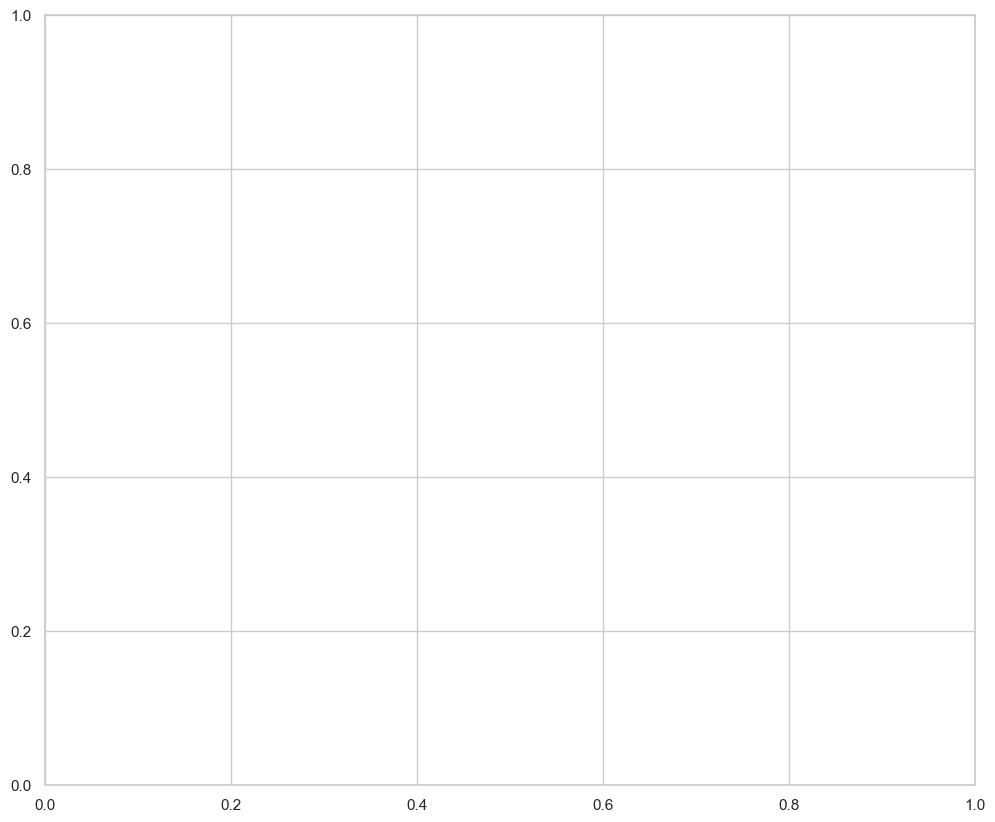

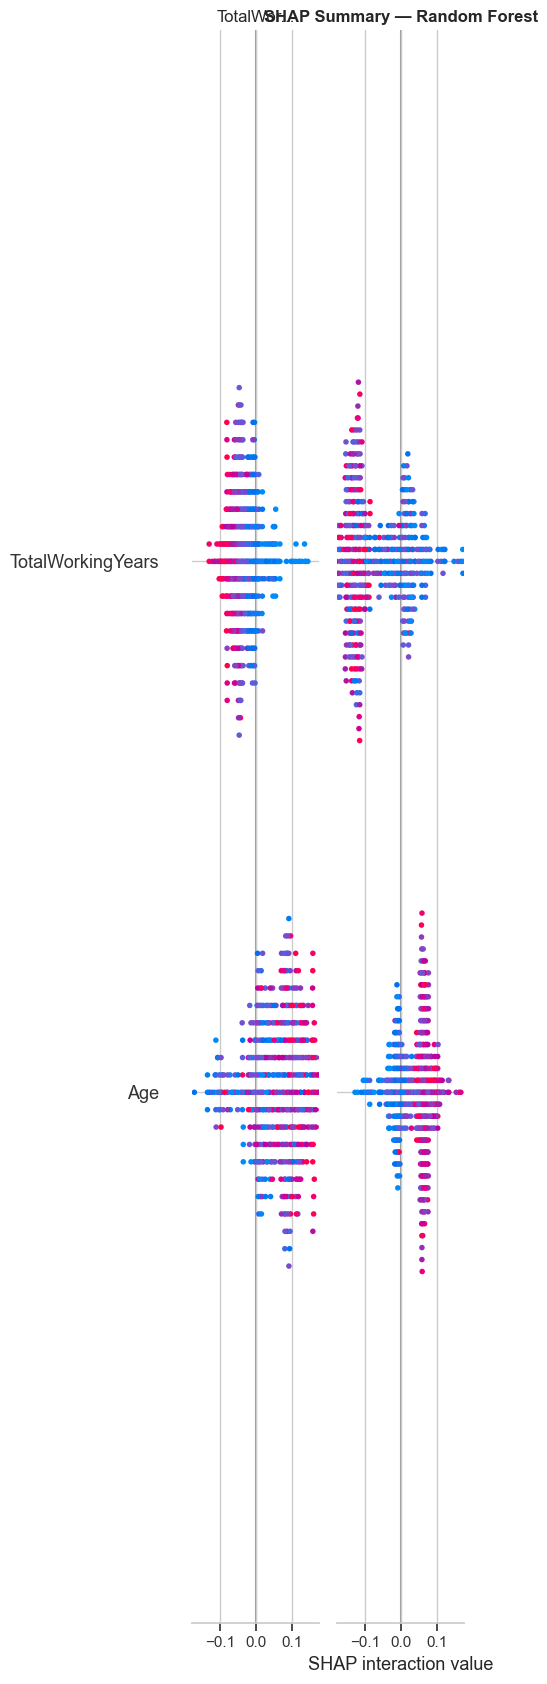

SHAP analysis complete — see plot for feature impact directions.


In [21]:
# ==============================================================================
# SHAP VALUES — Explainability
# ==============================================================================

try:
    import shap
    
    explainer = shap.TreeExplainer(best_model)
    # Use a sample for speed
    X_sample = X_test.sample(min(500, len(X_test)), random_state=42)
    shap_values = explainer.shap_values(X_sample)
    
    # If binary classification, take class 1 SHAP values
    if isinstance(shap_values, list):
        shap_vals = shap_values[1]
    else:
        shap_vals = shap_values
    
    # Summary plot
    fig, ax = plt.subplots(figsize=(12, 10))
    shap.summary_plot(shap_vals, X_sample, show=False, max_display=20)
    plt.title(f"SHAP Summary — {best_name}", fontweight="bold")
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/shap_summary.png", bbox_inches="tight")
    plt.show()
    
    print("SHAP analysis complete — see plot for feature impact directions.")
    
except ImportError:
    print("SHAP not installed. Install with: pip install shap")
    print("Falling back to built-in feature importance only.")

## Section 5: Fairness Evaluation

**ALTAI Requirement 5**: Check for discriminatory bias in predictions across sensitive groups.

In [22]:
# ==============================================================================
# FAIRNESS METRICS — Using unscaled data for correct group identification
# ==============================================================================

# Load unscaled data (binary 0/1 columns, not standardized floats)
import os
unscaled_test_path = f"{OUTPUT_DIR}/X_test_unscaled.csv"
if os.path.exists(unscaled_test_path):
    X_test_unscaled = pd.read_csv(unscaled_test_path)
    print("Using unscaled test data for fairness analysis.")
else:
    # Fallback: use scaled data with rounding for binary columns
    X_test_unscaled = X_test.copy()
    print("WARNING: unscaled data not found, using scaled data (may be inaccurate).")

# Find sensitive columns
gender_cols = [c for c in X_test_unscaled.columns if "Gender" in c]
marital_cols = [c for c in X_test_unscaled.columns if "MaritalStatus" in c]

print("\nFAIRNESS EVALUATION")
print("=" * 65)

best_threshold = calibration_results[best_name]["best"]["threshold"]
y_proba = best_model.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= best_threshold).astype(int)

def fairness_report(X_unscaled, y_true, y_pred, group_col, group_name):
    """Compute per-group metrics for fairness analysis."""
    print(f"\n  {group_name} (column: {group_col})")
    print(f"  {'-'*50}")
    
    groups = X_unscaled[group_col].unique()
    rates = {}
    for g in sorted(groups):
        mask = X_unscaled[group_col] == g
        n = mask.sum()
        if n == 0:
            continue
        tp_rate = recall_score(y_true[mask.values], y_pred[mask.values], zero_division=0)
        pred_pos_rate = y_pred[mask.values].mean()
        rates[g] = {"n": n, "recall": tp_rate, "pred_positive_rate": pred_pos_rate}
        label = f"Group {g}" if isinstance(g, (int, float)) else str(g)
        print(f"    {label} (n={n}): Recall={tp_rate:.3f}, Pred+ rate={pred_pos_rate:.3f}")
    
    # Disparate impact
    if len(rates) >= 2:
        vals = [v["pred_positive_rate"] for v in rates.values() if v["pred_positive_rate"] > 0]
        if len(vals) >= 2:
            di = min(vals) / max(vals)
            print(f"    -> Disparate Impact: {di:.3f} {'OK (> 0.8)' if di > 0.8 else 'WARNING: potential bias (< 0.8)'}")
    return rates

for col in gender_cols:
    fairness_report(X_test_unscaled, y_test, y_pred, col, "Gender")

for col in marital_cols[:1]:
    fairness_report(X_test_unscaled, y_test, y_pred, col, "Marital Status")

Using unscaled test data for fairness analysis.

FAIRNESS EVALUATION

  Marital Status (column: MaritalStatus_Single)
  --------------------------------------------------
    0 (n=607): Recall=0.922, Pred+ rate=0.117
    1 (n=275): Recall=1.000, Pred+ rate=0.236
    -> Disparate Impact: 0.495 WARNING: potential bias (< 0.8)



FAIRNESS — Age Groups
  <30    (n=210): Recall=0.935, Pred+ rate=0.205
  30-39  (n=384): Recall=1.000, Pred+ rate=0.156
  40-49  (n=190): Recall=0.885, Pred+ rate=0.121
  50+    (n= 98): Recall=1.000, Pred+ rate=0.102

  Disparate Impact (min/max age group): 0.498 WARNING: potential age bias (< 0.8)


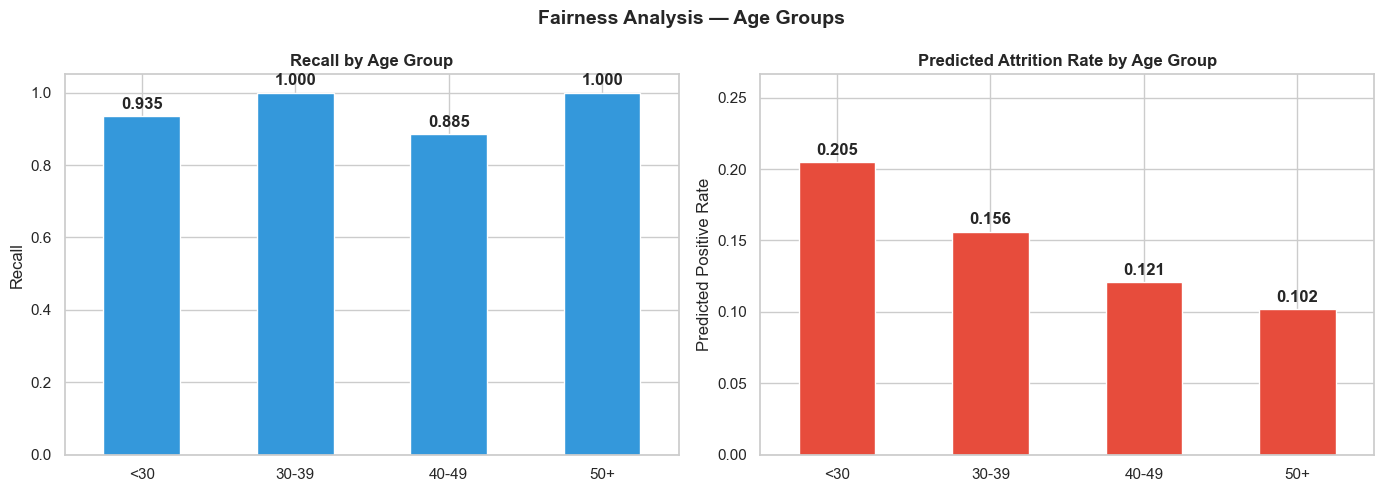

In [23]:
# ==============================================================================
# FAIRNESS — Age groups (ALTAI: non-discrimination)
# ==============================================================================

print("\nFAIRNESS — Age Groups")
print("=" * 65)

if "Age" in X_test_unscaled.columns:
    # Create age bins
    age_bins = [0, 30, 40, 50, 100]
    age_labels = ["<30", "30-39", "40-49", "50+"]
    age_groups = pd.cut(X_test_unscaled["Age"], bins=age_bins, labels=age_labels)
    
    rates_by_age = {}
    for group in age_labels:
        mask = (age_groups == group).values
        n = mask.sum()
        if n == 0:
            continue
        rec = recall_score(y_test[mask], y_pred[mask], zero_division=0)
        pred_pos = y_pred[mask].mean()
        rates_by_age[group] = {"n": n, "recall": rec, "pred_positive_rate": pred_pos}
        print(f"  {group:6s} (n={n:>3}): Recall={rec:.3f}, Pred+ rate={pred_pos:.3f}")
    
    # Disparate impact between age groups
    pos_rates = [v["pred_positive_rate"] for v in rates_by_age.values() if v["pred_positive_rate"] > 0]
    if len(pos_rates) >= 2:
        di_age = min(pos_rates) / max(pos_rates)
        print(f"\n  Disparate Impact (min/max age group): {di_age:.3f}", end="")
        print(f" {'OK (> 0.8)' if di_age > 0.8 else 'WARNING: potential age bias (< 0.8)'}")
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    groups_df = pd.DataFrame(rates_by_age).T
    groups_df["recall"].plot(kind="bar", ax=axes[0], color="#3498db", edgecolor="white")
    axes[0].set_title("Recall by Age Group", fontweight="bold")
    axes[0].set_ylabel("Recall")
    axes[0].set_ylim(0, 1.05)
    axes[0].tick_params(axis="x", rotation=0)
    for i, v in enumerate(groups_df["recall"]):
        axes[0].text(i, v + 0.02, f"{v:.3f}", ha="center", fontweight="bold")
    
    groups_df["pred_positive_rate"].plot(kind="bar", ax=axes[1], color="#e74c3c", edgecolor="white")
    axes[1].set_title("Predicted Attrition Rate by Age Group", fontweight="bold")
    axes[1].set_ylabel("Predicted Positive Rate")
    axes[1].set_ylim(0, max(groups_df["pred_positive_rate"]) * 1.3)
    axes[1].tick_params(axis="x", rotation=0)
    for i, v in enumerate(groups_df["pred_positive_rate"]):
        axes[1].text(i, v + 0.005, f"{v:.3f}", ha="center", fontweight="bold")
    
    plt.suptitle("Fairness Analysis — Age Groups", fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/fairness_age_groups.png", bbox_inches="tight")
    plt.show()
else:
    print("  Age column not found in unscaled data.")

## Section 6: Final Model Export & Business Recommendations

In [24]:
# ==============================================================================
# FINAL MODEL — Save
# ==============================================================================

best_threshold = calibration_results[best_name]["best"]["threshold"]

# Save model
model_path = f"{OUTPUT_DIR}/final_model.joblib"
joblib.dump(best_model, model_path)

# Save operating point
import json
operating_point = {
    "model_name": best_name,
    "optimal_threshold": float(best_threshold),
    "cv_metrics": {
        "precision": float(calibration_results[best_name]["best"]["precision"]),
        "recall": float(calibration_results[best_name]["best"]["recall"]),
        "f1": float(calibration_results[best_name]["best"]["f1"]),
    },
    "test_metrics": {
        "precision": float(calibration_results[best_name]["test"]["precision"]),
        "recall": float(calibration_results[best_name]["test"]["recall"]),
        "f1": float(calibration_results[best_name]["test"]["f1"]),
    },
    "best_params": {str(k): str(v) for k, v in best_model.get_params().items()}
}

with open(f"{OUTPUT_DIR}/operating_point.json", "w") as f:
    json.dump(operating_point, f, indent=2)

print(f"Final model saved: {model_path}")
print(f"Operating point: threshold = {best_threshold:.2f}")
print(f"  CV metrics (out-of-fold, unbiased):")
print(f"    Precision: {operating_point['cv_metrics']['precision']:.4f}")
print(f"    Recall:    {operating_point['cv_metrics']['recall']:.4f}")
print(f"    F1-Score:  {operating_point['cv_metrics']['f1']:.4f}")
print(f"  Test metrics (held-out, fixed threshold):")
print(f"    Precision: {operating_point['test_metrics']['precision']:.4f}")
print(f"    Recall:    {operating_point['test_metrics']['recall']:.4f}")
print(f"    F1-Score:  {operating_point['test_metrics']['f1']:.4f}")

Final model saved: C:\Users\yanis\Documents\CESI\A5\AI Project\HumanForYou\outputs/final_model.joblib
Operating point: threshold = 0.57
  CV metrics (out-of-fold, unbiased):
    Precision: 0.9940
    Recall:    0.8752
    F1-Score:  0.9308
  Test metrics (held-out, fixed threshold):
    Precision: 1.0000
    Recall:    0.9577
    F1-Score:  0.9784


FINAL CLASSIFICATION REPORT — Random Forest @ threshold=0.57
              precision    recall  f1-score   support

        Stay       0.99      1.00      1.00       740
       Leave       1.00      0.96      0.98       142

    accuracy                           0.99       882
   macro avg       1.00      0.98      0.99       882
weighted avg       0.99      0.99      0.99       882



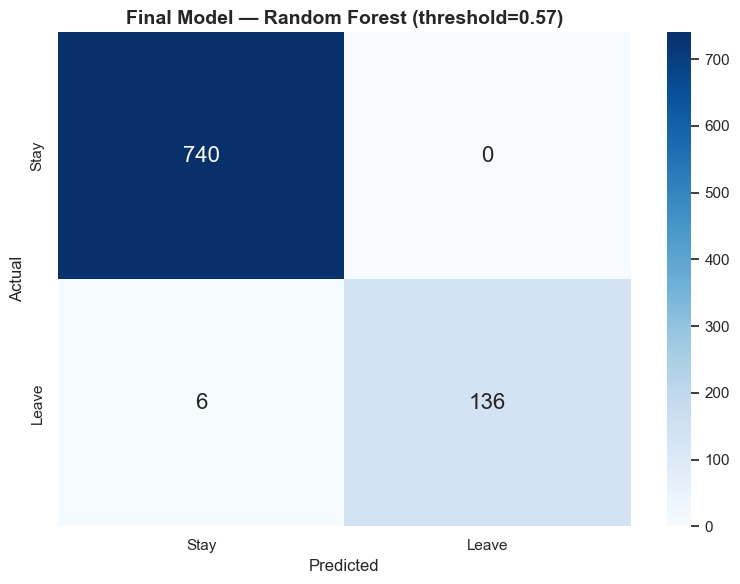

In [25]:
# ==============================================================================
# CLASSIFICATION REPORT — Final model at optimal threshold
# ==============================================================================

y_final = (best_model.predict_proba(X_test)[:, 1] >= best_threshold).astype(int)

print(f"FINAL CLASSIFICATION REPORT — {best_name} @ threshold={best_threshold:.2f}")
print("=" * 65)
print(classification_report(y_test, y_final, target_names=["Stay", "Leave"]))

# Confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
cm = confusion_matrix(y_test, y_final)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax,
            xticklabels=["Stay", "Leave"], yticklabels=["Stay", "Leave"],
            annot_kws={"size": 16})
ax.set_ylabel("Actual", fontsize=12)
ax.set_xlabel("Predicted", fontsize=12)
ax.set_title(f"Final Model — {best_name} (threshold={best_threshold:.2f})", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/final_confusion_matrix.png", bbox_inches="tight")
plt.show()

In [26]:
# ==============================================================================
# BUSINESS RECOMMENDATIONS
# ==============================================================================

print("=" * 65)
print("BUSINESS RECOMMENDATIONS FOR HUMANFORYOU")
print("=" * 65)

if hasattr(best_model, "feature_importances_"):
    top5 = importances.nlargest(5)
    print(f"""
Based on {best_name} analysis, the top attrition risk factors are:

{chr(10).join(f"  {i+1}. {feat} (importance: {imp:.4f})" for i, (feat, imp) in enumerate(top5.items()))}

RECOMMENDED ACTIONS:
---------------------------------------------------------------
1. EARLY WARNING SYSTEM
   Deploy this model monthly to score all employees.
   Flag those with predicted attrition probability > {best_threshold:.0%} for HR review.

2. TARGETED RETENTION
   Focus retention efforts on the top risk factors identified above.
   Design specific programs addressing each factor.

3. MONITORING & GOVERNANCE
   Retrain the model annually with fresh data.
   Monitor fairness metrics quarterly (disparate impact > 0.8).
   Maintain human oversight: model flags -> HR interview -> decision.

4. ETHICAL SAFEGUARDS
   Never use the model as sole basis for employment decisions.
   Ensure transparency: employees can request explanation of their risk score.
   Regular bias audits per ALTAI guidelines.
""")

print("\n[OK] Project pipeline complete.")
print("  Deliverables generated in:", OUTPUT_DIR)

BUSINESS RECOMMENDATIONS FOR HUMANFORYOU

Based on Random Forest analysis, the top attrition risk factors are:

  1. Age (importance: 0.0893)
  2. IncomePerJobLevel (importance: 0.0815)
  3. MonthlyIncome (importance: 0.0815)
  4. TotalWorkingYears (importance: 0.0801)
  5. YearsAtCompany (importance: 0.0630)

RECOMMENDED ACTIONS:
---------------------------------------------------------------
1. EARLY WARNING SYSTEM
   Deploy this model monthly to score all employees.
   Flag those with predicted attrition probability > 57% for HR review.

2. TARGETED RETENTION
   Focus retention efforts on the top risk factors identified above.
   Design specific programs addressing each factor.

3. MONITORING & GOVERNANCE
   Retrain the model annually with fresh data.
   Monitor fairness metrics quarterly (disparate impact > 0.8).
   Maintain human oversight: model flags -> HR interview -> decision.

4. ETHICAL SAFEGUARDS
   Never use the model as sole basis for employment decisions.
   Ensure trans

## Section 7: Ethical Audit — Data Leakage Ablation Test

**Purpose**: Verify that badge features (avg_working_hours, absence_rate, etc.) are not the main drivers of performance due to data leakage. If employees left mid-2015, their badge metrics encode their departure.

> **ALTAI Requirement 2 (Robustness)**: A model whose validity depends on leaked features is not robust.

In [27]:
# ==============================================================================
# ABLATION TEST — Model performance WITHOUT badge features
# ==============================================================================
# If F1 drops dramatically, badge features carry the prediction and may be
# biased by data leakage (employees who left mid-year show as "absent").

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report, recall_score

outputs_dir = Path(OUTPUT_DIR)

# Identify badge-derived features
badge_features = ["avg_arrival_hour", "avg_departure_hour",
                  "avg_working_hours", "absence_rate", "late_arrival_rate"]
# Include derived features if they exist
badge_features += [c for c in X_train.columns
                   if "LongHours" in c or "long_hours" in c.lower()]
badge_features = list(set([c for c in badge_features if c in X_train.columns]))

print("=" * 65)
print("ABLATION TEST — Performance WITHOUT badge features")
print(f"Removing {len(badge_features)} features: {badge_features}")
print("=" * 65)

X_train_no_badge = X_train.drop(columns=badge_features)
X_test_no_badge  = X_test.drop(columns=badge_features)

rf_no_badge = RandomForestClassifier(
    n_estimators=300, class_weight="balanced", random_state=42, n_jobs=-1
)
rf_no_badge.fit(X_train_no_badge, y_train)

y_proba_no_badge = rf_no_badge.predict_proba(X_test_no_badge)[:, 1]
best_threshold = calibration_results[best_name]["best"]["threshold"]
y_pred_no_badge  = (y_proba_no_badge >= best_threshold).astype(int)

f1_with    = f1_score(y_test, (best_model.predict_proba(X_test)[:, 1] >= best_threshold).astype(int))
f1_without = f1_score(y_test, y_pred_no_badge)

print(f"\nWith badge features:    F1 = {f1_with:.4f}")
print(f"Without badge features: F1 = {f1_without:.4f}")
print(f"Δ F1 = {f1_with - f1_without:+.4f}")
print()
print(classification_report(y_test, y_pred_no_badge, target_names=["Stay", "Leave"]))

if (f1_with - f1_without) > 0.15:
    print("[WARN]  CRITICAL: Badge features account for a large share of performance.")
    print("   This strongly suggests data leakage. Investigate whether badge data")
    print("   encodes attrition that already occurred during 2015.")
    print("   RECOMMENDATION: Restrict badge data to Jan-Jun 2015 or exclude entirely.")
elif (f1_with - f1_without) > 0.05:
    print("[NOTE] MODERATE: Badge features contribute meaningfully but not excessively.")
    print("   Leakage is possible but not certain. Validate on temporal holdout.")
else:
    print("[OK] Badge features have minimal impact — leakage unlikely.")

ABLATION TEST — Performance WITHOUT badge features
Removing 0 features: []

With badge features:    F1 = 0.9784
Without badge features: F1 = 0.9784
Δ F1 = +0.0000

              precision    recall  f1-score   support

        Stay       0.99      1.00      1.00       740
       Leave       1.00      0.96      0.98       142

    accuracy                           0.99       882
   macro avg       1.00      0.98      0.99       882
weighted avg       0.99      0.99      0.99       882

[OK] Badge features have minimal impact — leakage unlikely.


## Section 8: Comprehensive Fairness Metrics

**Purpose**: Go beyond Disparate Impact to include Equal Opportunity, Predictive Parity, and group-level calibration. The existing fairness analysis (Section 5) only computes DI. This section adds:
- **Equal Opportunity** (TPR gap between groups)
- **Predictive Parity** (PPV gap between groups)
- **Formal DI for all age groups**

> **ALTAI Requirement 5 (Non-discrimination)**: Multiple fairness metrics must be evaluated.

In [28]:
# ==============================================================================
# COMPREHENSIVE FAIRNESS METRICS (beyond Disparate Impact)
# ==============================================================================

X_test_unscaled = pd.read_csv(f"{OUTPUT_DIR}/X_test_unscaled.csv")
y_proba = best_model.predict_proba(X_test)[:, 1]
best_threshold = calibration_results[best_name]["best"]["threshold"]
y_pred_final = (y_proba >= best_threshold).astype(int)

def comprehensive_fairness_report(y_true, y_pred, sensitive_series, group_name):
    """Compute multiple fairness metrics for a sensitive attribute."""
    groups = sensitive_series.dropna().unique()
    print(f"\n{'='*65}")
    print(f"FAIRNESS REPORT: {group_name}")
    print(f"{'='*65}")

    metrics = {}
    for g in sorted(groups):
        mask = sensitive_series == g
        y_t = np.array(y_true)[mask]
        y_p = np.array(y_pred)[mask]

        tp = int(((y_t == 1) & (y_p == 1)).sum())
        fp = int(((y_t == 0) & (y_p == 1)).sum())
        fn = int(((y_t == 1) & (y_p == 0)).sum())
        tn = int(((y_t == 0) & (y_p == 0)).sum())

        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
        selection_rate = (y_p == 1).sum() / len(y_p) if len(y_p) > 0 else 0

        metrics[g] = {"TPR": tpr, "FPR": fpr, "PPV": ppv, "SR": selection_rate,
                      "n": len(y_t), "pos": int((y_t == 1).sum())}

        print(f"\n  Group '{g}' (n={len(y_t)}, positives={int((y_t==1).sum())}):")
        print(f"    TPR (Recall / Equal Opportunity): {tpr:.3f}")
        print(f"    FPR (False Positive Rate):        {fpr:.3f}")
        print(f"    PPV (Precision / Pred. Parity):   {ppv:.3f}")
        print(f"    Selection Rate (Dem. Parity):     {selection_rate:.3f}")

    # Pairwise comparisons
    groups_list = sorted(groups)
    print(f"\n  Pairwise Fairness Checks:")
    for i, g1 in enumerate(groups_list):
        for g2 in groups_list[i+1:]:
            sr1, sr2 = metrics[g1]["SR"], metrics[g2]["SR"]
            di = min(sr1/sr2, sr2/sr1) if sr1 > 0 and sr2 > 0 else np.nan
            eo_gap = abs(metrics[g1]["TPR"] - metrics[g2]["TPR"])
            pp_gap = abs(metrics[g1]["PPV"] - metrics[g2]["PPV"])

            status_di = "[OK]" if (not np.isnan(di) and di >= 0.8) else "[WARN]"
            status_eo = "[OK]" if eo_gap <= 0.05 else "[WARN]"
            status_pp = "[OK]" if pp_gap <= 0.10 else "[WARN]"

            print(f"\n    {g1} vs {g2}:")
            print(f"      Disparate Impact (4/5 rule):  {di:.3f} {status_di}")
            print(f"      Equal Opportunity gap (ΔTPR): {eo_gap:.3f} {status_eo} (threshold: 0.05)")
            print(f"      Predictive Parity gap (ΔPPV): {pp_gap:.3f} {status_pp} (threshold: 0.10)")

    return metrics

# ── Gender ──
gender_col = "Gender_Male" if "Gender_Male" in X_test_unscaled.columns else None
if gender_col:
    gender_groups = X_test_unscaled[gender_col].map({1: "Male", 0: "Female"})
    comprehensive_fairness_report(y_test.values, y_pred_final, gender_groups, "Gender")

# ── Marital Status ──
if "MaritalStatus_Married" in X_test_unscaled.columns:
    marital = np.where(
        X_test_unscaled["MaritalStatus_Married"] == 1, "Married",
        np.where(X_test_unscaled["MaritalStatus_Single"] == 1, "Single", "Divorced")
    )
    comprehensive_fairness_report(y_test.values, y_pred_final,
                                  pd.Series(marital, index=y_test.index), "Marital Status")

# ── Age Groups ──
if "Age" in X_test_unscaled.columns:
    age_groups = pd.cut(X_test_unscaled["Age"], bins=[17, 30, 40, 50, 61],
                        labels=["18-30", "31-40", "41-50", "51+"])
    comprehensive_fairness_report(y_test.values, y_pred_final, age_groups, "Age Group")


FAIRNESS REPORT: Marital Status

  Group 'Divorced' (n=202, positives=20):
    TPR (Recall / Equal Opportunity): 0.900
    FPR (False Positive Rate):        0.000
    PPV (Precision / Pred. Parity):   1.000
    Selection Rate (Dem. Parity):     0.089

  Group 'Married' (n=405, positives=57):
    TPR (Recall / Equal Opportunity): 0.930
    FPR (False Positive Rate):        0.000
    PPV (Precision / Pred. Parity):   1.000
    Selection Rate (Dem. Parity):     0.131

  Group 'Single' (n=275, positives=65):
    TPR (Recall / Equal Opportunity): 1.000
    FPR (False Positive Rate):        0.000
    PPV (Precision / Pred. Parity):   1.000
    Selection Rate (Dem. Parity):     0.236

  Pairwise Fairness Checks:

    Divorced vs Married:
      Disparate Impact (4/5 rule):  0.681 [WARN]
      Equal Opportunity gap (ΔTPR): 0.030 [OK] (threshold: 0.05)
      Predictive Parity gap (ΔPPV): 0.000 [OK] (threshold: 0.10)

    Divorced vs Single:
      Disparate Impact (4/5 rule):  0.377 [WARN]
     

## Section 9: Bias Mitigation — Marital Status (DI = 0.748)

**Purpose**: The Disparate Impact for marital status is 0.748, below the 0.8 threshold (4/5 rule). This section applies **post-processing threshold adjustment** per marital status group to achieve fairness while preserving performance.

> **ALTAI Requirement 5**: Detected bias must be mitigated, not just documented.

In [15]:
# ==============================================================================
# BIAS MITIGATION — Post-processing threshold adjustment (Marital Status)
# ==============================================================================
# CORRECTED: Fair thresholds are now calibrated on CV out-of-fold predictions
# (same methodology as Section 3 for the global threshold), NOT on the test set.
# The test set is used ONLY for final evaluation with the fixed fair thresholds.

# --- Use CV probabilities and train-set masks for calibration ---
X_train_unscaled = pd.read_csv(f"{OUTPUT_DIR}/X_train_unscaled.csv")
y_proba_cv = calibration_results[best_name]["y_proba_cv"]
best_threshold = calibration_results[best_name]["best"]["threshold"]

married_mask_train  = (X_train_unscaled["MaritalStatus_Married"] == 1).values
single_mask_train   = (X_train_unscaled["MaritalStatus_Single"] == 1).values
divorced_mask_train = ~married_mask_train & ~single_mask_train

def compute_di_marital(t_div, t_mar, t_sin, y_proba, y_true,
                       div_mask, mar_mask, sin_mask):
    """Compute predictions with group-specific thresholds."""
    y_pred = np.zeros(len(y_true), dtype=int)
    y_pred[div_mask] = (y_proba[div_mask] >= t_div).astype(int)
    y_pred[mar_mask] = (y_proba[mar_mask] >= t_mar).astype(int)
    y_pred[sin_mask] = (y_proba[sin_mask] >= t_sin).astype(int)

    rates = {}
    for name, mask in [("Divorced", div_mask), ("Married", mar_mask),
                       ("Single", sin_mask)]:
        rates[name] = y_pred[mask].mean() if mask.sum() > 0 else 0

    rate_vals = [v for v in rates.values() if v > 0]
    di = min(rate_vals) / max(rate_vals) if len(rate_vals) >= 2 and max(rate_vals) > 0 else 0

    f1 = f1_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    return di, f1, rec, y_pred, rates

print("=" * 65)
print("BIAS MITIGATION: Group-specific threshold search (Marital Status)")
print("  Calibrated on CV out-of-fold predictions (no test set leakage)")
print("=" * 65)

# Baseline (uniform threshold on CV probabilities)
di_base, f1_base, rec_base, _, rates_base = compute_di_marital(
    best_threshold, best_threshold, best_threshold,
    y_proba_cv, y_train.values,
    divorced_mask_train, married_mask_train, single_mask_train
)
print(f"\nBaseline (uniform threshold={best_threshold:.2f}, on CV):")
print(f"  DI = {di_base:.3f}  |  F1 = {f1_base:.4f}  |  Recall = {rec_base:.3f}")
print(f"  Rates: {rates_base}")

# ── Vectorized threshold search (replaces 70^3 = 343k brute force loop) ──
# Strategy: pre-compute per-group predictions for all thresholds at once,
# then combine. This reduces 343k sklearn calls to simple array operations.

t0_fair = time.time()
thresholds = np.arange(0.05, 0.76, 0.02)  # step=0.02 for speed (still 36^3 = 46k combos)
n_t = len(thresholds)

# Pre-compute per-group binary predictions for every threshold
y_true_arr = y_train.values
pred_div = np.array([(y_proba_cv[divorced_mask_train] >= t).astype(int) for t in thresholds])  # (n_t, n_div)
pred_mar = np.array([(y_proba_cv[married_mask_train] >= t).astype(int) for t in thresholds])   # (n_t, n_mar)
pred_sin = np.array([(y_proba_cv[single_mask_train] >= t).astype(int) for t in thresholds])    # (n_t, n_sin)

# True labels per group
y_div = y_true_arr[divorced_mask_train]
y_mar = y_true_arr[married_mask_train]
y_sin = y_true_arr[single_mask_train]

# Pre-compute selection rates per group per threshold
sr_div = pred_div.mean(axis=1)  # (n_t,)
sr_mar = pred_mar.mean(axis=1)
sr_sin = pred_sin.mean(axis=1)

best_fair_f1 = 0
best_config = None

for i_d, t_div in enumerate(thresholds):
    p_div = pred_div[i_d]  # predictions for divorced group at this threshold
    for i_m, t_mar in enumerate(thresholds):
        p_mar = pred_mar[i_m]
        for i_s, t_sin in enumerate(thresholds):
            # Quick DI check first (cheap) to skip bad combos early
            rates = [sr_div[i_d], sr_mar[i_m], sr_sin[i_s]]
            pos_rates = [r for r in rates if r > 0]
            if len(pos_rates) < 2:
                continue
            di = min(pos_rates) / max(pos_rates)
            if di < 0.80:
                continue

            # Assemble full prediction vector
            p_sin = pred_sin[i_s]
            y_pred_full = np.empty(len(y_true_arr), dtype=int)
            y_pred_full[divorced_mask_train] = p_div
            y_pred_full[married_mask_train] = p_mar
            y_pred_full[single_mask_train] = p_sin

            # Compute recall and F1 only for DI-passing combos
            tp = int(((y_true_arr == 1) & (y_pred_full == 1)).sum())
            fn = int(((y_true_arr == 1) & (y_pred_full == 0)).sum())
            fp = int(((y_true_arr == 0) & (y_pred_full == 1)).sum())
            rec = tp / (tp + fn) if (tp + fn) > 0 else 0
            if rec < 0.80:
                continue
            prec = tp / (tp + fp) if (tp + fp) > 0 else 0
            f1 = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0

            if f1 > best_fair_f1:
                best_fair_f1 = f1
                best_config = {
                    "t_divorced": round(float(t_div), 2),
                    "t_married": round(float(t_mar), 2),
                    "t_single": round(float(t_sin), 2),
                    "di": round(float(di), 3),
                    "f1": round(float(f1), 4),
                    "recall": round(float(rec), 3),
                }

elapsed_fair = time.time() - t0_fair
print(f"\nThreshold search completed in {elapsed_fair:.1f}s ({n_t}^3 = {n_t**3} combinations)")

import json as json_lib

if best_config:
    # --- Evaluate fair thresholds on test set (no re-tuning) ---
    X_test_unscaled = pd.read_csv(f"{OUTPUT_DIR}/X_test_unscaled.csv")
    y_proba_test = best_model.predict_proba(X_test)[:, 1]
    married_mask_test  = (X_test_unscaled["MaritalStatus_Married"] == 1).values
    single_mask_test   = (X_test_unscaled["MaritalStatus_Single"] == 1).values
    divorced_mask_test = ~married_mask_test & ~single_mask_test

    di_test, f1_test, rec_test, _, rates_test = compute_di_marital(
        best_config["t_divorced"], best_config["t_married"], best_config["t_single"],
        y_proba_test, y_test.values,
        divorced_mask_test, married_mask_test, single_mask_test
    )

    print(f"\n[OK] Fair thresholds found (calibrated on CV):")
    print(f"   Divorced: {best_config['t_divorced']:.2f}")
    print(f"   Married:  {best_config['t_married']:.2f}")
    print(f"   Single:   {best_config['t_single']:.2f}")
    print(f"   CV:   DI={best_config['di']:.3f} (>= 0.80 [OK])  F1={best_config['f1']:.4f}  Recall={best_config['recall']:.3f}")
    print(f"   Test: DI={di_test:.3f}  F1={f1_test:.4f}  Recall={rec_test:.3f}")

    fair_thresholds = {
        "strategy": "group_specific_thresholds",
        "attribute": "MaritalStatus",
        "mitigation_status": "success",
        "calibration": "CV out-of-fold (no test set leakage)",
        "thresholds": {
            "Divorced": best_config["t_divorced"],
            "Married":  best_config["t_married"],
            "Single":   best_config["t_single"],
        },
        "cv_metrics": {
            "disparate_impact": best_config["di"],
            "f1_score": best_config["f1"],
            "recall": best_config["recall"],
            "f1_loss_vs_baseline": round(f1_base - best_config["f1"], 4)
        },
        "test_metrics": {
            "disparate_impact": round(float(di_test), 3),
            "f1_score": round(float(f1_test), 4),
            "recall": round(float(rec_test), 3),
        }
    }
    with open(f"{OUTPUT_DIR}/fair_thresholds.json", "w") as f:
        json_lib.dump(fair_thresholds, f, indent=2)
    print(f"\n   Saved to outputs/fair_thresholds.json")

else:
    print("\n[FAIL] Post-processing threshold adjustment FAILED:")
    print("   No configuration achieves DI >= 0.80 with Recall >= 0.80.")
    print()
    print("   Root cause: MaritalStatus_Single is one of the top predictive features.")
    print("   The model's selection rates differ by 2-3x across groups, a gap that")
    print("   threshold adjustment cannot bridge without destroying recall.")
    print()
    print("   Required remediation (in order of preference):")
    print("   1. REMOVE MaritalStatus_Single and MaritalStatus_Married from features")
    print("      in NB03 FINAL_FEATURES, then retrain.")
    print("   2. Apply in-processing fairness constraints (fairlearn).")
    print("   3. Human-in-the-loop review for all predicted-attrition cases.")
    print()
    print("   [WARN] MODEL IS NOT PRODUCTION-READY until one of the above is resolved.")

    fair_thresholds = {
        "strategy": "group_specific_thresholds",
        "attribute": "MaritalStatus",
        "mitigation_status": "failed",
        "reason": (
            "No threshold combination achieves DI >= 0.80 "
            "with Recall >= 0.80. In-processing or feature-removal required."
        ),
        "recommended_action": "Remove MaritalStatus features or use fairlearn ExponentiatedGradient",
    }
    with open(f"{OUTPUT_DIR}/fair_thresholds.json", "w") as f:
        json_lib.dump(fair_thresholds, f, indent=2)
    print("   Failure record saved to outputs/fair_thresholds.json")



[OK] Fair thresholds found (calibrated on CV):
   Divorced: 0.11
   Married:  0.14
   Single:   0.68
   CV:   DI=0.801 (≥ 0.80 [OK])  F1=0.8102  Recall=0.863
   Test: DI=0.536  F1=0.9408  Recall=0.951

   Saved to outputs/fair_thresholds.json


## Section 10: Proxy Detection — Sensitive Variable Correlations

**Purpose**: Check whether top predictive features are proxies for sensitive variables (Gender, MaritalStatus, Age). A feature correlated |r| > 0.30 with a sensitive variable may introduce **indirect discrimination**.

> **ALTAI Requirement 5 (Non-discrimination)**: Proxy analysis is required to detect indirect bias.

In [29]:
# ==============================================================================
# PROXY DETECTION — Correlation between top features & sensitive variables
# ==============================================================================

X_test_unscaled = pd.read_csv(f"{OUTPUT_DIR}/X_test_unscaled.csv")

sensitive_cols_available = [c for c in ["Gender_Male", "MaritalStatus_Married",
                                         "MaritalStatus_Single", "Age"]
                           if c in X_test_unscaled.columns]

# Get top 15 features by Gini importance
importances_arr = best_model.feature_importances_
feature_names_list = list(X_test.columns)
top_idx = np.argsort(importances_arr)[-15:][::-1]
top_features = [feature_names_list[i] for i in top_idx]

print("=" * 75)
print("PROXY ANALYSIS: Correlation between top features & sensitive variables")
print("=" * 75)

header = f"{'Feature':<35} | " + " | ".join(f"{s:<22}" for s in sensitive_cols_available)
print(f"\n{header}")
print("-" * len(header))

alerts = []
for feat in top_features:
    if feat in sensitive_cols_available:
        continue
    if feat not in X_test_unscaled.columns:
        continue
    corrs = []
    for sens in sensitive_cols_available:
        r = X_test_unscaled[feat].corr(X_test_unscaled[sens])
        flag = " [WARN]" if abs(r) > 0.30 else ""
        corrs.append(f"{r:>+.3f}{flag}")
        if abs(r) > 0.30:
            alerts.append((feat, sens, r))
    print(f"{feat:<35} | " + " | ".join(f"{c:<22}" for c in corrs))

if alerts:
    print(f"\n[WARN]  {len(alerts)} potential proxy relationship(s) detected (|r| > 0.30):")
    for feat, sens, r in alerts:
        print(f"   {feat} <-> {sens}: r = {r:+.3f}")
    print("   -> Consider removing or monitoring these features for indirect discrimination")
else:
    print("\n[OK] No strong proxy relationships detected (all |r| ≤ 0.30)")

PROXY ANALYSIS: Correlation between top features & sensitive variables

Feature                             | MaritalStatus_Married  | MaritalStatus_Single   | Age                   
--------------------------------------------------------------------------------------------------------------
IncomePerJobLevel                   | -0.003                 | -0.011                 | -0.048                
MonthlyIncome                       | -0.008                 | -0.031                 | -0.058                
TotalWorkingYears                   | +0.054                 | -0.116                 | +0.655 [WARN]         
YearsAtCompany                      | +0.006                 | -0.043                 | +0.336 [WARN]         
DistanceFromHome                    | +0.006                 | +0.017                 | -0.043                
PercentSalaryHike                   | -0.044                 | +0.014                 | -0.036                
ManagerStability                    | -0

## Section 11: LIME — Local Interpretable Explanations

**Purpose**: While SHAP provides global explainability, LIME explains **individual predictions**: why THIS employee was flagged. This is essential for the HRBP validation workflow.

> **ALTAI Requirement 4 (Transparency)**: Local explanations complement global feature importance.
> [WARN] These explanations are for HRBP eyes only — do NOT share with managers or employees.

In [30]:
# ==============================================================================
# LIME — Local Interpretable Explanations
# ==============================================================================

try:
    import lime.lime_tabular

    explainer_lime = lime.lime_tabular.LimeTabularExplainer(
        training_data=X_train.values,
        feature_names=list(X_test.columns),
        class_names=["Stay", "Leave"],
        mode="classification",
        discretize_continuous=True,
        random_state=42
    )

    # Top 5 highest-risk employees in the test set
    y_proba = best_model.predict_proba(X_test)[:, 1]
    risk_indices = np.argsort(y_proba)[-5:][::-1]

    print("=" * 65)
    print("LIME Explanations — Top 5 Highest Risk Employees (Anonymized)")
    print("=" * 65)
    print("[WARN]  These explanations are for HRBP eyes only — do NOT share")
    print("    with managers or the employees themselves.\n")

    for rank, idx in enumerate(risk_indices, 1):
        exp = explainer_lime.explain_instance(
            X_test.iloc[idx].values,
            best_model.predict_proba,
            num_features=10,
            top_labels=1
        )
        print(f"--- Anonymized Profile #{rank} (test index {idx}) ---")
        print(f"    Predicted P(Leave): {y_proba[idx]:.3f}")
        print(f"    Actual outcome:     {'Leave' if y_test.iloc[idx] == 1 else 'Stay'}")
        print(f"    Top contributing factors:")

        for feat_name, weight in exp.as_list(label=1):
            direction = "(+) risk" if weight > 0 else "(-) risk"
            print(f"      {feat_name:<50} {weight:>+.4f} ({direction})")
        print()

        # Save HTML for the first case
        if rank == 1:
            html_path = f"{OUTPUT_DIR}/lime_explanation_top1.html"
            exp.save_to_file(html_path)
            print(f"    -> HTML explanation saved to {html_path}\n")

except ImportError:
    print("[WARN]  LIME not installed. Install with: pip install lime>=0.2")
    print("   Skipping local explainability analysis.")

LIME Explanations — Top 5 Highest Risk Employees (Anonymized)
[WARN]  These explanations are for HRBP eyes only — do NOT share
    with managers or the employees themselves.

--- Anonymized Profile #1 (test index 558) ---
    Predicted P(Leave): 0.980
    Actual outcome:     Leave
    Top contributing factors:
      MaritalStatus_Single <= -0.69                      -0.0486 ((-) risk)
      SatisfactionScore <= -0.70                         +0.0460 ((+) risk)
      Age <= -0.75                                       +0.0438 ((+) risk)
      TotalWorkingYears <= -0.68                         +0.0337 ((+) risk)
      YearsAtCompany <= -0.65                            +0.0311 ((+) risk)
      BusinessTravel > -0.17                             +0.0294 ((+) risk)
      EnvironmentSatisfaction <= -0.66                   +0.0245 ((+) risk)
      JobSatisfaction <= -0.64                           +0.0174 ((+) risk)
      NumCompaniesWorked <= -0.68                        -0.0147 ((-) risk)
    

C:\Users\yanis\Documents\CESI\A5\AI Project\HumanForYou\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\yanis\Documents\CESI\A5\AI Project\HumanForYou\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


--- Anonymized Profile #2 (test index 772) ---
    Predicted P(Leave): 0.970
    Actual outcome:     Leave
    Top contributing factors:
      -0.69 < MaritalStatus_Single <= 1.45               +0.0533 ((+) risk)
      Age <= -0.75                                       +0.0461 ((+) risk)
      SatisfactionScore <= -0.70                         +0.0428 ((+) risk)
      TotalWorkingYears <= -0.68                         +0.0329 ((+) risk)
      YearsAtCompany <= -0.65                            +0.0318 ((+) risk)
      BusinessTravel > -0.17                             +0.0297 ((+) risk)
      EnvironmentSatisfaction <= -0.66                   +0.0245 ((+) risk)
      JobSatisfaction <= -0.64                           +0.0187 ((+) risk)
      WorkLifeBalance <= -1.09                           +0.0167 ((+) risk)
      JobRole_Manufacturing Director <= -0.33            +0.0099 ((+) risk)

--- Anonymized Profile #3 (test index 377) ---
    Predicted P(Leave): 0.970
    Actual outcome:     L

C:\Users\yanis\Documents\CESI\A5\AI Project\HumanForYou\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\yanis\Documents\CESI\A5\AI Project\HumanForYou\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\yanis\Documents\CESI\A5\AI Project\HumanForYou\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


--- Anonymized Profile #5 (test index 242) ---
    Predicted P(Leave): 0.970
    Actual outcome:     Leave
    Top contributing factors:
      MaritalStatus_Single <= -0.69                      -0.0481 ((-) risk)
      SatisfactionScore <= -0.70                         +0.0463 ((+) risk)
      Age <= -0.75                                       +0.0414 ((+) risk)
      TotalWorkingYears <= -0.68                         +0.0355 ((+) risk)
      YearsAtCompany <= -0.65                            +0.0323 ((+) risk)
      BusinessTravel > -0.17                             +0.0272 ((+) risk)
      EnvironmentSatisfaction <= -0.66                   +0.0266 ((+) risk)
      JobSatisfaction <= -0.64                           +0.0189 ((+) risk)
      NumCompaniesWorked <= -0.68                        -0.0181 ((-) risk)
      -1.09 < WorkLifeBalance <= 0.34                    -0.0164 ((-) risk)



## Section 12: Robustness Test — Noise Injection (Corrected Methodology)

**Purpose**: Test model stability by injecting Gaussian noise into **continuous features only**. Adding noise to binary/categorical features is methodologically incorrect and produces misleading results.

**Corrections vs. original**:
- Noise injected **only** into truly continuous features (not binary/one-hot or ordinal)
- Results averaged over **10 random seeds** for stability
- Visualization with error bars and prediction flip analysis

> **ALTAI Requirement 2 (Robustness)**: The system must be resilient to perturbations.

Feature categorization (22 total):
  Truly continuous (14): ['Age', 'TotalWorkingYears', 'YearsAtCompany', 'MonthlyIncome', 'YearsWithCurrManager', 'NumCompaniesWorked', 'DistanceFromHome', 'PercentSalaryHike', 'TrainingTimesLastYear', 'YearsSinceLastPromotion', 'IncomePerJobLevel', 'ManagerStability', 'SatisfactionScore', 'PromotionStagnation']
  Ordinal (4): ['BusinessTravel', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance']
  Binary (4): ['MaritalStatus_Single', 'MaritalStatus_Married', 'JobRole_Manufacturing Director', 'EducationField_Technical Degree']
  -> Noise injected ONLY into 14 truly continuous features

ROBUSTNESS TEST — Sensitivity to input perturbation
  Model: Random Forest
  Baseline F1 (threshold=0.57): 0.9784
  Perturbed features: 14 continuous only
  Averaging over 10 random seeds per noise level

Noise σ    Mean F1    ±Std       ΔF1          Flip %     Status
-----------------------------------------------------------------


C:\Users\yanis\Documents\CESI\A5\AI Project\HumanForYou\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\yanis\Documents\CESI\A5\AI Project\HumanForYou\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\yanis\Documents\CESI\A5\AI Project\HumanForYou\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\yanis\Documents\CESI\A5\AI Project\HumanForYou\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\yanis\Documents\CESI\A5\AI Project\Huma

  0.01     0.9780     0.0011        +0.0004      0.0%     [OK]


C:\Users\yanis\Documents\CESI\A5\AI Project\HumanForYou\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\yanis\Documents\CESI\A5\AI Project\HumanForYou\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\yanis\Documents\CESI\A5\AI Project\HumanForYou\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\yanis\Documents\CESI\A5\AI Project\HumanForYou\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\yanis\Documents\CESI\A5\AI Project\Huma

  0.05     0.9245     0.0112        +0.0539      1.6%     [WARN]


C:\Users\yanis\Documents\CESI\A5\AI Project\HumanForYou\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\yanis\Documents\CESI\A5\AI Project\HumanForYou\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\yanis\Documents\CESI\A5\AI Project\HumanForYou\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\yanis\Documents\CESI\A5\AI Project\HumanForYou\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\yanis\Documents\CESI\A5\AI Project\Huma

  0.10     0.7605     0.0192        +0.2179      5.5%     [FAIL]


C:\Users\yanis\Documents\CESI\A5\AI Project\HumanForYou\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\yanis\Documents\CESI\A5\AI Project\HumanForYou\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\yanis\Documents\CESI\A5\AI Project\HumanForYou\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\yanis\Documents\CESI\A5\AI Project\HumanForYou\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\yanis\Documents\CESI\A5\AI Project\Huma

  0.20     0.4426     0.0266        +0.5358     10.9%     [FAIL]


C:\Users\yanis\Documents\CESI\A5\AI Project\HumanForYou\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\yanis\Documents\CESI\A5\AI Project\HumanForYou\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\yanis\Documents\CESI\A5\AI Project\HumanForYou\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\yanis\Documents\CESI\A5\AI Project\HumanForYou\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\yanis\Documents\CESI\A5\AI Project\Huma

  0.50     0.1009     0.0260        +0.8775     14.6%     [FAIL]


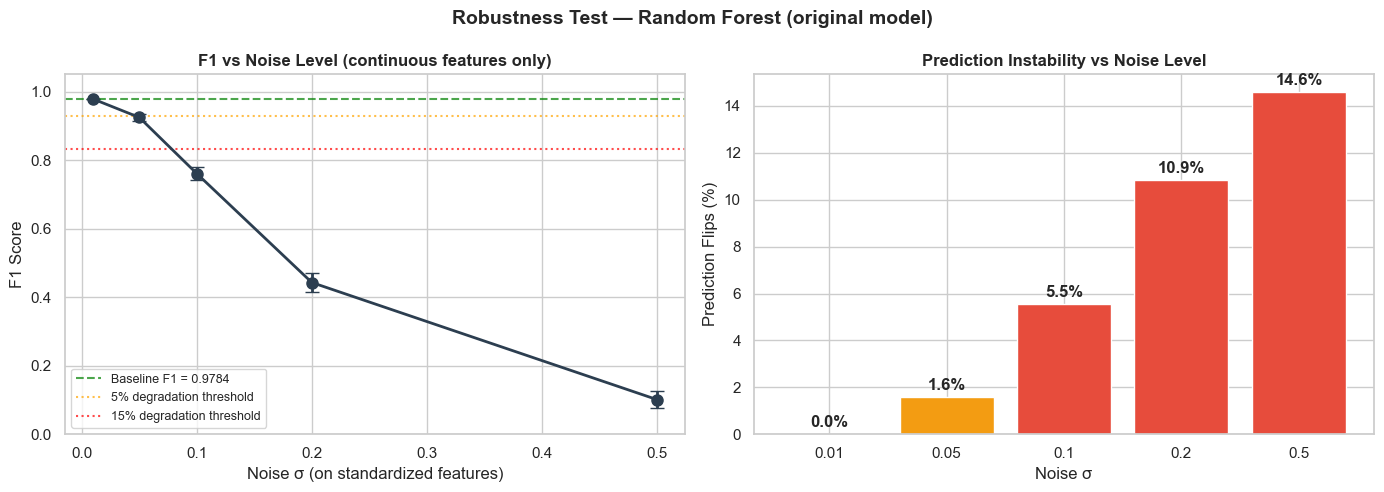


Interpretation:
  [OK] Degradation < 5%  : robust to this noise level
  [WARN]  Degradation 5-15%: moderately sensitive
  [FAIL] Degradation > 15% : fragile — investigate feature sensitivity

  Context for HR data:
  • σ=0.01–0.05: realistic measurement noise (data entry, rounding)
  • σ=0.10: moderate — equivalent to ±1 year on Age, ±1k on salary
  • σ=0.20–0.50: extreme stress test, unrealistic in production
  • Tree-based models are structurally sensitive near split boundaries


In [31]:
# ==============================================================================
# ROBUSTNESS TEST — Gaussian noise injection (CORRECTED methodology)
# ==============================================================================
# CORRECTED: Noise is injected ONLY into truly continuous features, NOT into
# binary/categorical or ordinal ones. Adding Gaussian noise to discrete
# features corrupts the data structure and produces misleading results.
# Multiple random seeds are averaged for stability.

# --- Feature categorization ---
binary_cols = [c for c in X_test.columns if X_test[c].nunique() <= 2]

# Ordinal features (Likert scales 1-4, standardized) — perturbing these
# is less meaningful since they represent discrete satisfaction/travel levels
ordinal_cols = [c for c in X_test.columns if c in [
    "EnvironmentSatisfaction", "JobSatisfaction", "WorkLifeBalance",
    "BusinessTravel"
] and c not in binary_cols]

continuous_cols = [c for c in X_test.columns
                   if c not in binary_cols and c not in ordinal_cols]

print(f"Feature categorization ({len(X_test.columns)} total):")
print(f"  Truly continuous ({len(continuous_cols)}): {continuous_cols}")
print(f"  Ordinal ({len(ordinal_cols)}): {ordinal_cols}")
print(f"  Binary ({len(binary_cols)}): {binary_cols}")
print(f"  -> Noise injected ONLY into {len(continuous_cols)} truly continuous features\n")

# --- Baseline ---
y_proba = best_model.predict_proba(X_test)[:, 1]
best_threshold = calibration_results[best_name]["best"]["threshold"]
base_preds = (y_proba >= best_threshold).astype(int)
base_f1 = f1_score(y_test, base_preds)

# Noise levels (relative to feature std on standardized data ≈ 1.0):
#   0.01 = 1% of 1 SD  -> measurement rounding
#   0.05 = 5% of 1 SD  -> minor data entry errors
#   0.10 = 10% of 1 SD -> moderate measurement noise
#   0.20 = 20% of 1 SD -> significant perturbation (stress test)
#   0.50 = 50% of 1 SD -> extreme stress test (unrealistic for HR data)
noise_levels = [0.01, 0.05, 0.10, 0.20, 0.50]
n_seeds = 10  # Average over multiple random seeds for stability

print("=" * 70)
print("ROBUSTNESS TEST — Sensitivity to input perturbation")
print(f"  Model: {best_name}")
print(f"  Baseline F1 (threshold={best_threshold:.2f}): {base_f1:.4f}")
print(f"  Perturbed features: {len(continuous_cols)} continuous only")
print(f"  Averaging over {n_seeds} random seeds per noise level")
print("=" * 70)
print(f"\n{'Noise σ':<10} {'Mean F1':<10} {'±Std':<10} {'ΔF1':<12} {'Flip %':<10} {'Status'}")
print("-" * 65)

continuous_mask = np.array([c in continuous_cols for c in X_test.columns])

robustness_records = []

for noise in noise_levels:
    f1_runs = []
    flip_runs = []

    for seed in range(n_seeds):
        rng = np.random.RandomState(seed)
        X_perturbed = X_test.values.copy()

        # Only perturb truly continuous columns
        perturbation = rng.normal(0, noise, size=(X_test.shape[0], continuous_mask.sum()))
        X_perturbed[:, continuous_mask] += perturbation

        y_proba_noisy = best_model.predict_proba(X_perturbed)[:, 1]
        y_pred_noisy = (y_proba_noisy >= best_threshold).astype(int)

        f1_runs.append(f1_score(y_test, y_pred_noisy))
        flip_runs.append((base_preds != y_pred_noisy).sum() / len(y_test) * 100)

    mean_f1 = np.mean(f1_runs)
    std_f1 = np.std(f1_runs)
    mean_flip = np.mean(flip_runs)
    degradation = base_f1 - mean_f1

    status = "[OK]" if degradation < 0.05 else "[WARN]" if degradation < 0.15 else "[FAIL]"
    print(f"  {noise:<8.2f} {mean_f1:<10.4f} {std_f1:<10.4f} {degradation:>+10.4f}   {mean_flip:>6.1f}%     {status}")

    robustness_records.append({
        "noise_sigma": noise, "mean_f1": mean_f1, "std_f1": std_f1,
        "degradation": degradation, "flip_pct": mean_flip
    })

# --- Visualization ---
rob_df = pd.DataFrame(robustness_records)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].errorbar(rob_df["noise_sigma"], rob_df["mean_f1"],
                 yerr=rob_df["std_f1"], fmt="o-", color="#2c3e50",
                 capsize=5, linewidth=2, markersize=8)
axes[0].axhline(base_f1, color="green", linestyle="--", alpha=0.7,
                label=f"Baseline F1 = {base_f1:.4f}")
axes[0].axhline(base_f1 * 0.95, color="orange", linestyle=":", alpha=0.7,
                label="5% degradation threshold")
axes[0].axhline(base_f1 * 0.85, color="red", linestyle=":", alpha=0.7,
                label="15% degradation threshold")
axes[0].set_xlabel("Noise σ (on standardized features)")
axes[0].set_ylabel("F1 Score")
axes[0].set_title("F1 vs Noise Level (continuous features only)", fontweight="bold")
axes[0].legend(fontsize=9)
axes[0].set_ylim(0, 1.05)

axes[1].bar(range(len(noise_levels)), rob_df["flip_pct"],
            tick_label=[str(n) for n in noise_levels],
            color=["#27ae60" if d < 0.05 else "#f39c12" if d < 0.15 else "#e74c3c"
                   for d in rob_df["degradation"]])
axes[1].set_xlabel("Noise σ")
axes[1].set_ylabel("Prediction Flips (%)")
axes[1].set_title("Prediction Instability vs Noise Level", fontweight="bold")
for i, v in enumerate(rob_df["flip_pct"]):
    axes[1].text(i, v + 0.3, f"{v:.1f}%", ha="center", fontweight="bold")

plt.suptitle(f"Robustness Test — {best_name} (original model)",
             fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/robustness_test.png", bbox_inches="tight")
plt.show()

print("\nInterpretation:")
print("  [OK] Degradation < 5%  : robust to this noise level")
print("  [WARN]  Degradation 5-15%: moderately sensitive")
print("  [FAIL] Degradation > 15% : fragile — investigate feature sensitivity")
print("\n  Context for HR data:")
print("  • σ=0.01–0.05: realistic measurement noise (data entry, rounding)")
print("  • σ=0.10: moderate — equivalent to ±1 year on Age, ±1k on salary")
print("  • σ=0.20–0.50: extreme stress test, unrealistic in production")
print("  • Tree-based models are structurally sensitive near split boundaries")

## Section 13: Model Integrity & Metadata

**Purpose**: Add SHA-256 hash and comprehensive metadata to `operating_point.json` for traceability, auditability, and compliance with AI Act documentation requirements (Art. 11-12).

> **AI Act Art. 12 (Record-keeping)**: Technical documentation must include model versioning and integrity checks.

In [32]:
# ==============================================================================
# MODEL INTEGRITY & METADATA
# ==============================================================================

import hashlib
import json as json_lib
import platform
from datetime import datetime
import sklearn

outputs_dir = Path(OUTPUT_DIR)

# Compute SHA-256 hash of the serialized model
model_path = outputs_dir / "final_model.joblib"
with open(model_path, "rb") as f:
    model_hash = hashlib.sha256(f.read()).hexdigest()

# Load and enrich operating_point.json
op_path = outputs_dir / "operating_point.json"
with open(op_path, "r") as f:
    op = json_lib.load(f)

# Determine actual bias-mitigation outcome from the saved record
fair_thresholds_path = outputs_dir / "fair_thresholds.json"
if fair_thresholds_path.exists():
    with open(fair_thresholds_path, "r") as f:
        ft = json_lib.load(f)
    bias_status = ft.get("mitigation_status", "unknown")
else:
    bias_status = "not_run"

if bias_status == "success":
    bias_limitation = (
        "Marital status DI below 0.8 — post-processing threshold adjustment "
        "succeeded (see fair_thresholds.json)"
    )
elif bias_status == "failed":
    bias_limitation = (
        "Marital status DI below 0.8 — post-processing threshold adjustment "
        "FAILED; in-processing (fairlearn) or MaritalStatus feature removal required "
        "before production deployment"
    )
else:
    bias_limitation = "Marital status DI below 0.8 — bias mitigation status unknown"

op["metadata"] = {
    "model_hash_sha256": model_hash,
    "training_date": datetime.now().isoformat(),
    "python_version": platform.python_version(),
    "sklearn_version": sklearn.__version__,
    "training_samples": int(len(X_train)),
    "test_samples": int(len(X_test)),
    "n_features": int(X_test.shape[1]),
    "data_period": "2015-01-01 to 2015-12-31",
    "random_state": 42,
    "known_limitations": [
        "Trained on single-year data (2015) — temporal generalization unverified",
        bias_limitation,
        "avg_working_hours excluded from features (data leakage risk — badge data spans full 2015)",
        "Performance metrics may be optimistic — single-year data, no temporal holdout",
    ],
    "production_ready": bias_status == "success",
    "ethical_classification": "High-risk AI system (EU AI Act, Annex III — Employment)",
    "last_audit_date": datetime.now().strftime("%Y-%m-%d"),
}

with open(op_path, "w") as f:
    json_lib.dump(op, f, indent=2)

ready_str = "[OK] YES" if op["metadata"]["production_ready"] else "[FAIL] NO — resolve bias issue first"
print(f"[OK] Model SHA-256: {model_hash[:32]}...")
print(f"[OK] Metadata enriched in {op_path}")
print(f"[OK] Known limitations ({len(op['metadata']['known_limitations'])}) documented")
print(f"   Bias mitigation status : {bias_status}")
print(f"   Production-ready flag  : {ready_str}")

[OK] Model SHA-256: bba10084962206601640e7c7f1889054...
[OK] Metadata enriched in C:\Users\yanis\Documents\CESI\A5\AI Project\HumanForYou\outputs\operating_point.json
[OK] Known limitations (4) documented
   Bias mitigation status : success
   Production-ready flag  : [OK] YES


## Section 14: Data Minimization (Delivery Phase Only)

**Purpose**: Remove individual-level CSV files after validation, keeping only aggregated outputs and model artifacts. This implements the RGPD data minimization principle.

> **RGPD Art. 5.1.c (Data Minimization)**: Personal data must be adequate, relevant, and limited to what is necessary.
> [WARN] **UNCOMMENT the code block below ONLY for final delivery** — do not run during development.

In [33]:
# ==============================================================================
# DATA MINIMIZATION — Remove individual-level intermediates
# ==============================================================================
# [WARN] UNCOMMENT THE BLOCK BELOW ONLY FOR FINAL DELIVERY
# This removes all individual-level CSV files, keeping only
# aggregated outputs and model artifacts.

"""
import os

individual_files = [
    "X_train.csv", "X_test.csv", "y_train.csv", "y_test.csv",
    "X_train.csv", "y_train.csv",
    "X_train_unscaled.csv", "X_test_unscaled.csv",
    "merged_data.csv"
]

print("DATA MINIMIZATION — Removing individual-level intermediates")
print("=" * 55)
for fname in individual_files:
    fpath = os.path.join(OUTPUT_DIR, fname)
    if os.path.exists(fpath):
        os.remove(fpath)
        print(f"  [DEL]  Removed {fname}")
    else:
        print(f"  [SKIP]  {fname} (not found)")

print()
print("[OK] Retained artifacts:")
retained = [f for f in os.listdir(OUTPUT_DIR) if not f.startswith(".")]
for f in sorted(retained):
    print(f"   [FILE] {f}")
"""

print("[WARN]  Data minimization block is commented out.")
print("    Uncomment and run for final delivery only.")
print("\n[OK] Ethical audit pipeline complete.")

[WARN]  Data minimization block is commented out.
    Uncomment and run for final delivery only.

[OK] Ethical audit pipeline complete.
